![example](images/director_shot.jpeg)

# Microsoft Movie Recommendations

**Author:** Lia Elwonger
***

## Overview

Microsoft is perhaps best know as a software company, but has many media holding, perhaps most notably in video games via their Xbox consoles and games. How might this company leverage its capital and brand to enter into the film industry?

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [25]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from datetime import date
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams.update({'font.size': 16})

We will be using data from IMDB and The Numbers in our analysis.
Our target variable for all three recommendations will be total profit.
We will look to see if there is any association between the target and three variables:
1. Film Genre
2. Time of Release
3. Director

The data on budgets, revenue and release date will come from the website "The Numbers" and looks like this:

In [26]:
budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


The data on genres will come from IMDB.

In [27]:
titles_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
titles_df.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


Data for the directors names and films they worked on will come from IMDB as well and is spread over two files.

In [28]:
principles_df = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
principles_df.head(3)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN


In [29]:
names_df = pd.read_csv("data/zippedData/imdb.name.basics.csv.gz") 
names_df.head(3)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

We will begin by joining the dataframes containing the genre information and the budget information and droping some columns that are irrelevant to our analysis.

In [30]:
# Here you run your code to clean the data
budgets_df.set_index('movie', inplace=True)
titles_df.set_index('primary_title', inplace=True)
budget_genre_df = budgets_df.join(titles_df, how='inner')
budget_genre_df.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)
budget_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3815 non-null   int64 
 1   release_date       3815 non-null   object
 2   production_budget  3815 non-null   object
 3   domestic_gross     3815 non-null   object
 4   worldwide_gross    3815 non-null   object
 5   tconst             3815 non-null   object
 6   start_year         3815 non-null   int64 
 7   genres             3743 non-null   object
dtypes: int64(2), object(6)
memory usage: 268.2+ KB


The data is missing a few rows of genre information. It is a fairly small bit of data, likely form films that are either difficult to categorize or no one bothered to on IMDB. We will just drop them.

In [31]:
budget_genre_df.dropna(inplace = True)
budget_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3743 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3743 non-null   int64 
 1   release_date       3743 non-null   object
 2   production_budget  3743 non-null   object
 3   domestic_gross     3743 non-null   object
 4   worldwide_gross    3743 non-null   object
 5   tconst             3743 non-null   object
 6   start_year         3743 non-null   int64 
 7   genres             3743 non-null   object
dtypes: int64(2), object(6)
memory usage: 263.2+ KB


Since microsoft is likely to spend a conisderable amount on a film to make it worth their time, we will filter the data only contain movies with budgets over $10 million.
Since film trends are fairly variable, we will also drop movies that didn't release in the past 20 years.
We will also insert a column that calculates the global profit for each film, which will require turning the objects in the budget and gross columns into integers.

In [32]:
def money_to_int(df_column):
    """
    Takes in a pandas df column with strings representing dollar and returns the column in int
    """
    return df_column.map(lambda x: int(x[1:].replace(',','')))

In [33]:
budget_genre_df['production_budget'] = money_to_int(budget_genre_df['production_budget'])
budget_genre_df = budget_genre_df[budget_genre_df['production_budget'] >= 10000000]
budget_genre_df = budget_genre_df[budget_genre_df['start_year'] >= 2001]
budget_genre_df['worldwide_gross'] = money_to_int(budget_genre_df['worldwide_gross'])
budget_genre_df['domestic_gross'] = money_to_int(budget_genre_df['domestic_gross'])
budget_genre_df['profit'] = budget_genre_df.worldwide_gross - budget_genre_df.production_budget
budget_genre_df['release_date'] = budget_genre_df['release_date'].map(lambda x: parser.parse(x))
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,start_year,genres,profit
10 Days in a Madhouse,48,2015-11-11,12000000,14616,14616,tt3453052,2015,Drama,-11985384
12 Rounds,37,2009-03-27,20000000,12234694,17306648,tt3517850,2017,"Action,Drama,Romance",-2693352
12 Strong,64,2018-01-19,35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",36118378
12 Years a Slave,18,2013-10-18,20000000,56671993,181025343,tt2024544,2013,"Biography,Drama,History",161025343
127 Hours,6,2010-11-05,18000000,18335230,60217171,tt1542344,2010,"Adventure,Biography,Drama",42217171


We are now in a position to analyze the relationship between both genre and release date with profit, but don't yet have the data on directors. TO do so we will join this data base with the other two, group it by director and calculate the mean profit that each director has made. 

In [34]:
principles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   tconst      1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   nconst      1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


As we can see the principles database is missing values from job and character, but we are only interest in the category which is sufficient to identify directors so we will drop those columns

In [35]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


The names data base is missing a significant amount of data, but all that is relevant to us is the missing professions. We will have to drop any data mising professions and then join the tables. Since we are only interested in directors we will also drop any category rows that list something other than director.

In [36]:
principles_df = principles_df.drop(columns = ['job','characters'])
names_df = names_df.drop(columns = ['birth_year', 'death_year', 'known_for_titles']).dropna()
principles_df.set_index('nconst', inplace=True)
names_df.set_index('nconst', inplace=True)
name_profession_df = principles_df.join(names_df, how='inner')
name_profession_df = name_profession_df[name_profession_df["category"].str.contains('director')==True]
name_profession_df.head()

,tconst,ordering,category,primary_name,primary_profession
nconst,,,,,
nm0000080,tt0069049,5,director,Orson Welles,"actor,director,writer"
nm0000095,tt1605783,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt1182350,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt2334873,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt2870756,5,director,Woody Allen,"writer,director,actor"


We will now join it with the budget and genre table.

In [37]:
budget_genre_df.set_index('tconst', inplace=True)
name_profession_df.reset_index(inplace = True)
name_profession_df.set_index('tconst', inplace=True)
complete_df = name_profession_df.join(budget_genre_df, how='inner')
complete_df = complete_df.drop(columns = ['ordering','primary_profession', 'id'])
complete_df.head(3)

,nconst,category,primary_name,release_date,production_budget,domestic_gross,worldwide_gross,start_year,genres,profit
tconst,,,,,,,,,,
tt0249516,nm0440415,director,Lawrence Kasanoff,2012-12-31,45000000,0,73706,2012,"Action,Animation,Comedy",-44926294
tt0293429,nm2585406,director,Simon McQuoid,1995-08-18,20000000,70433227,122133227,2021,"Action,Adventure,Fantasy",102133227
tt0337692,nm0758574,director,Walter Salles,2013-03-22,25000000,720828,9313302,2012,"Adventure,Drama,Romance",-15686698


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

We will begin analyzing the genre data by constructing a table which give us the mean profit for each genre as well as the std deviation. This will give us a reasonable representation of the expected profit from each genre and a rough measure of the risk.

In [38]:
# Constructing a list of all the genres in the database
genre_list = []
for entry in list(budget_genre_df['genres'].dropna()):
    genres = entry.split(',')
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)

In [39]:
def genre_filter(df, genre):
    """
    Takes a pd dataframe and filters the dataframe to only contain those movies of the specified genre
    """
    return df[df["genres"].str.contains(genre)==True]


In [40]:
def mean_genre_profit_table(df, genres):
    """
    Takes a dataframe and a list of all the genres in the df and returns a df with the mean and std
    of the profit in millions for each genre
    """
    m_s_dict = {}
    for genre in genres:
        profit_df = genre_filter(budget_genre_df, genre)["profit"]
        data_mean = profit_df.mean()/1000000
        data_std = profit_df.std()/1000000
        m_s_dict[genre] = [data_mean, data_std]
    output_df = pd.DataFrame.from_dict(m_s_dict)
    output_df.index = ['mean', 'std']
    output_df = output_df.transpose().sort_values('mean')
    return output_df   

In [42]:
genre_stats_df = mean_genre_profit_table(budget_genre_df, genre_list)
genre_stats_df.head()

,mean,std
News,26.187239,26.084511
Western,33.310964,103.813905
War,36.605565,70.851314
Crime,51.035553,128.653109
Drama,51.207308,117.121185


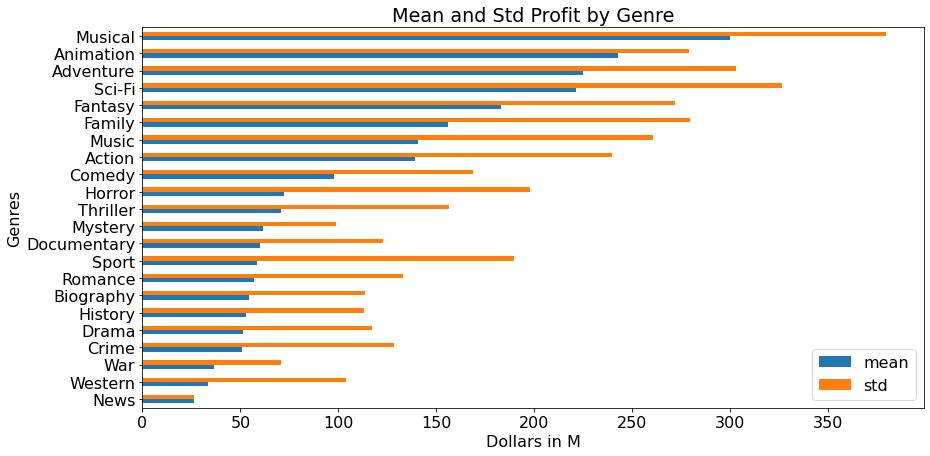

In [43]:
genre_stats_df.sort_values(by = 'mean', inplace = True)
genre_stats_plot = genre_stats_df.plot.barh()
genre_stats_plot.set(xlabel= "Dollars in M", ylabel="Genres", title="Mean and Std Profit by Genre");

Musicals have been one of the more sucessful genres in the past 20 year, but have been fairly risky with fairly high variance in the profit they earn. Animation offers a good tradeoff between expect profit and risk and likely synergizes more easily with microsofts expertise.

To determine what release month is best we will construct a bar chart of the mean profit by month.

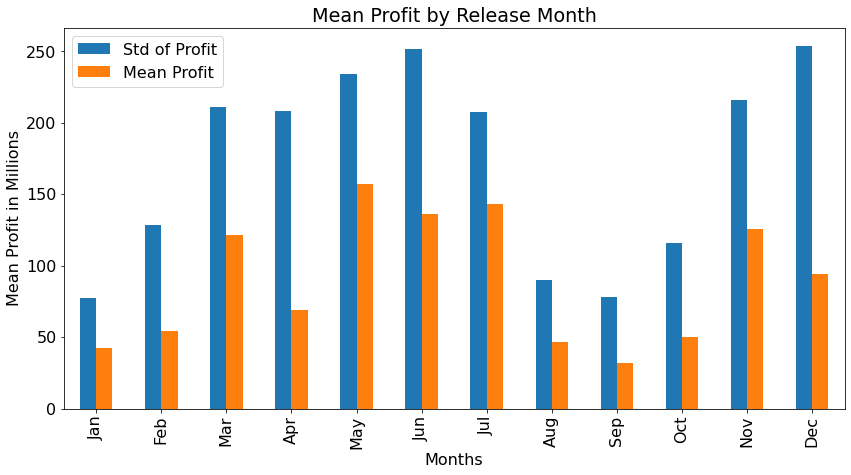

In [44]:
release_df = pd.DataFrame()
release_df['release_month'] = budget_genre_df['release_date'].map(lambda x: x.month)
release_df['profit'] = budget_genre_df['profit'].map(lambda x: x/1000000)
release_df.reset_index(inplace = True)
release_df.drop(columns = ['tconst'])
mean_df = release_df.groupby(by = 'release_month').mean()
release_df = release_df.groupby(by = 'release_month').std()
release_df.rename(columns = {'profit' : 'Std of Profit'}, inplace=True)
release_df['Mean Profit'] = mean_df['profit']
release_plot = release_df.plot.bar()
release_plot.set(xlabel= "Months", ylabel="Mean Profit in Millions", title="Mean Profit by Release Month")
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
release_plot.set_xticklabels(xlabels);

It appears that May has the highest mean profit, but july is almost as good with less variance. I would suggest a July release from this data.

To determine what director would be reasonable we will filter the database to only include animated movies and then group the database by director and sort them by the mean profit from their films to find the top five candidates.

In [52]:
animated_direct_df = complete_df[complete_df['genres'].str.contains('Animation')==True]
animated_direct_df = animated_direct_df.drop(columns = ['start_year', 'worldwide_gross', 'domestic_gross', 'production_budget'])
animated_direct_df = animated_direct_df.groupby(by='primary_name').mean()
animated_direct_df.sort_values(by='profit', ascending = False, inplace = True)
animated_direct_df.head()

,profit
primary_name,
Chris Buck,1.122470e+09
Jennifer Lee,1.122470e+09
Brad Bird,1.042521e+09
Kyle Balda,1.023032e+09
Eric Guillon,9.597278e+08


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***